<h1> Amazon Apparel Recommendations </h1>



### Overview of the data

In [0]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

# Text Semantics based product similarity using word2vec

In [0]:

# credits: https://www.kaggle.com/c/word2vec-nlp-tutorial#part-2-word-vectors
# Custom Word2Vec using your own text data.
# Do NOT RUN this code.
# It is meant as a reference to build your own Word2Vec when you have 
# lots of data.

'''
# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 1    # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print ("Training model...")
model = word2vec.Word2Vec(sen_corpus, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context)
    
'''

In [0]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.

'''
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
'''

#if you do NOT have RAM >= 12GB, use the code below.
with open('word2vec_model', 'rb') as handle:
    model = pickle.load(handle)


In [0]:
# Utility functions

def get_word_vec(sentence, doc_id, m_name):
    # sentence : title of the apparel
    # doc_id: document id in our corpus
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            # if the word in our courpus is not there in the google word2vec corpus, we are just ignoring it
            vec.append(np.zeros(shape=(300,)))
    # we will return a numpy array of shape (#number of words in title * 300 ) 300 = len(w2v_model[word])
    # each row represents the word2vec representation of each word (weighted/avg) in given sentance 
    return  np.array(vec)

def get_distance(vec1, vec2):
    # vec1 = np.array(#number_of_words_title1 * 300), each row is a vector of length 300 corresponds to each word in give title
    # vec2 = np.array(#number_of_words_title2 * 300), each row is a vector of length 300 corresponds to each word in give title
    
    final_dist = []
    # for each vector in vec1 we caluclate the distance(euclidean) to all vectors in vec2
    for i in vec1:
        dist = []
        for j in vec2:
            # np.linalg.norm(i-j) will result the euclidean distance between vectors i, j
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    # final_dist = np.array(#number of words in title1 * #number of words in title2)
    # final_dist[i,j] = euclidean distance between vectors i, j
    return np.array(final_dist)


def heat_map_w2v(sentence1, sentence2, url, doc_id1, doc_id2, model):
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentence1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentence2, doc_id2, model)

    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)

    
    
    # devide whole figure into 2 parts 1st part displays heatmap 2nd part displays image of apparel
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1],height_ratios=[2,1]) 
    fig = plt.figure(figsize=(15,15))
    
    ax = plt.subplot(gs[0])
    # ploting the heap map based on the pairwise distances
    ax = sns.heatmap(np.round(s1_s2_dist,4), annot=True)
    # set the x axis labels as recommended apparels title
    ax.set_xticklabels(sentence2.split())
    # set the y axis labels as input apparels title
    ax.set_yticklabels(sentence1.split())
    # set title as recommended apparels title
    ax.set_title(sentence2)
    
    ax = plt.subplot(gs[1])
    # we remove all grids and axis labels for image
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    display_img(url, ax, fig)
    
    plt.show()

In [0]:
# vocab = stores all the words that are there in google w2v model
# vocab = model.wv.vocab.keys() # if you are using Google word2Vec

vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

### [9.2] Average Word2Vec product similarity.

In [0]:
doc_id = 0
w2v_title = []
# for every title we build a avg vector representation
for i in data['title']:
    w2v_title.append(build_avg_vec(i, 300, doc_id,'avg'))
    doc_id += 1

# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title = np.array(w2v_title)


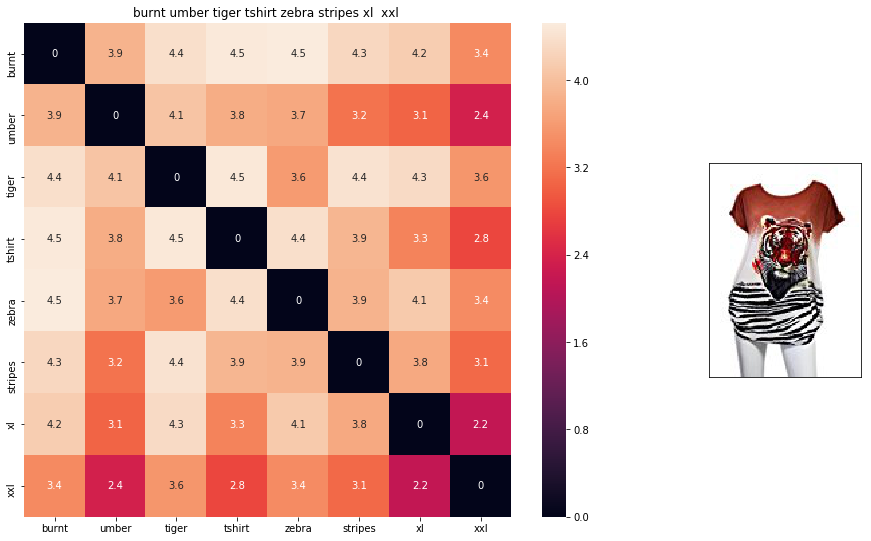

ASIN : B00JXQB5FQ
BRAND : Si Row
euclidean distance from given input image : 0.000690534


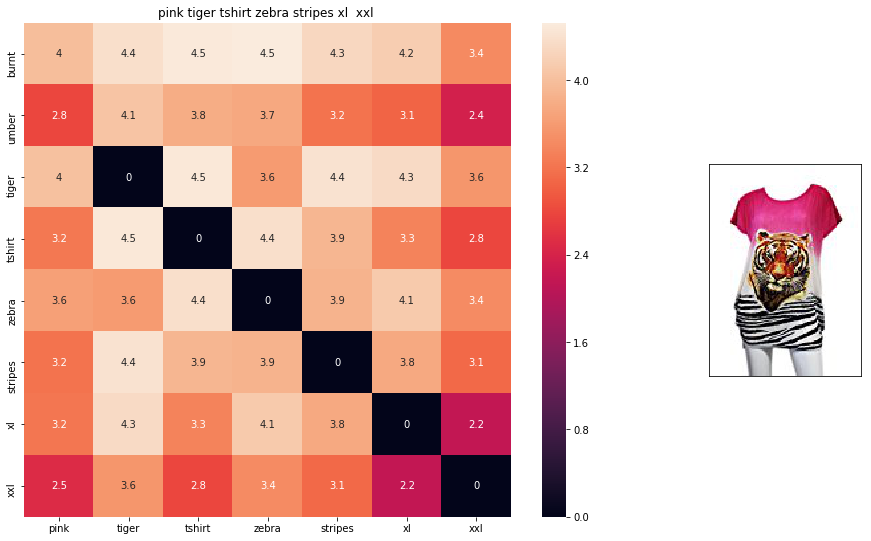

ASIN : B00JXQASS6
BRAND : Si Row
euclidean distance from given input image : 0.589193


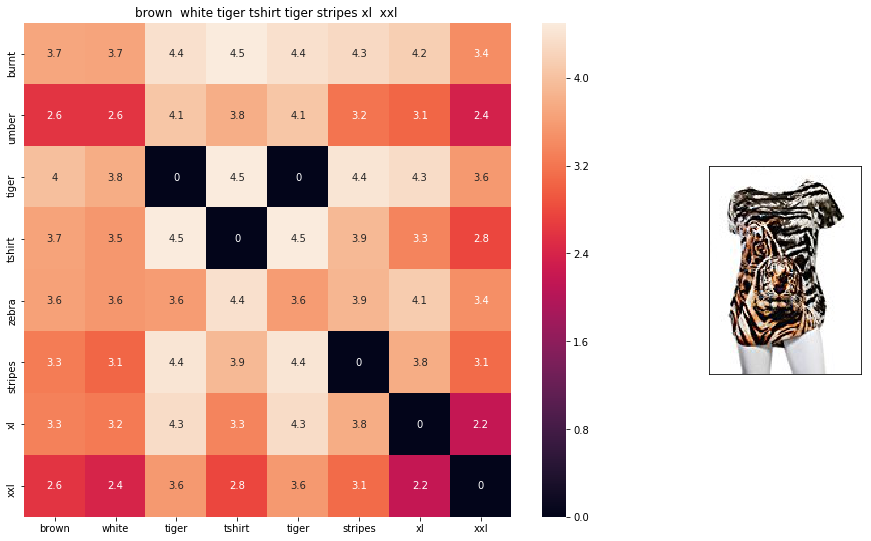

ASIN : B00JXQCWTO
BRAND : Si Row
euclidean distance from given input image : 0.700344


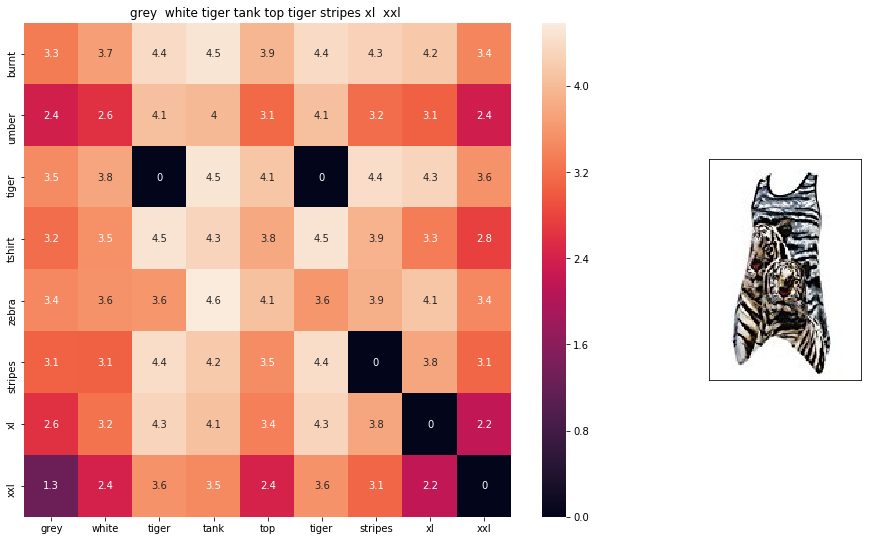

ASIN : B00JXQAFZ2
BRAND : Si Row
euclidean distance from given input image : 0.89284


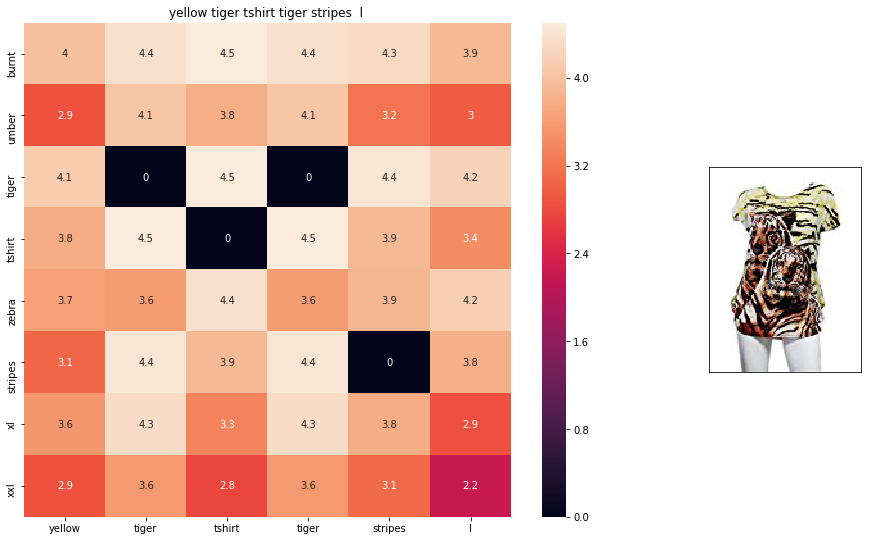

ASIN : B00JXQCUIC
BRAND : Si Row
euclidean distance from given input image : 0.956013


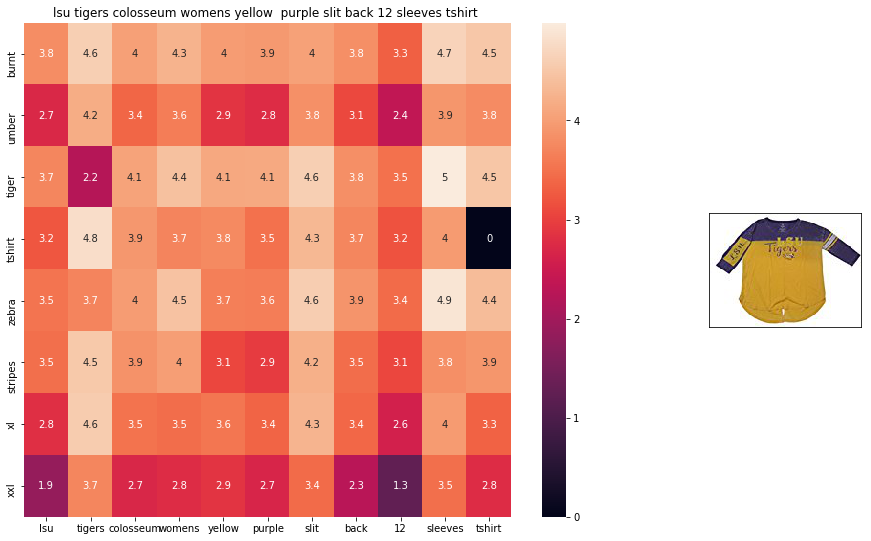

ASIN : B073R5Q8HD
BRAND : Colosseum
euclidean distance from given input image : 1.02297


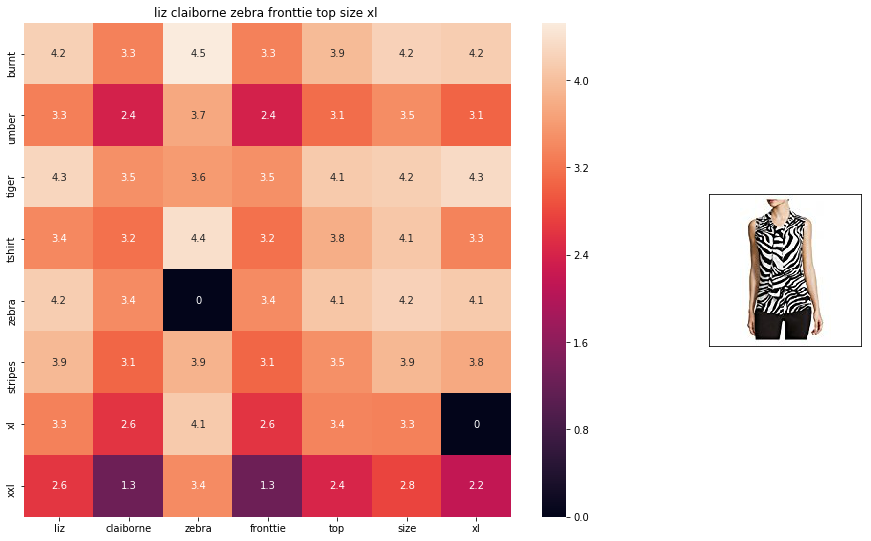

ASIN : B06XBY5QXL
BRAND : Liz Claiborne
euclidean distance from given input image : 1.06693


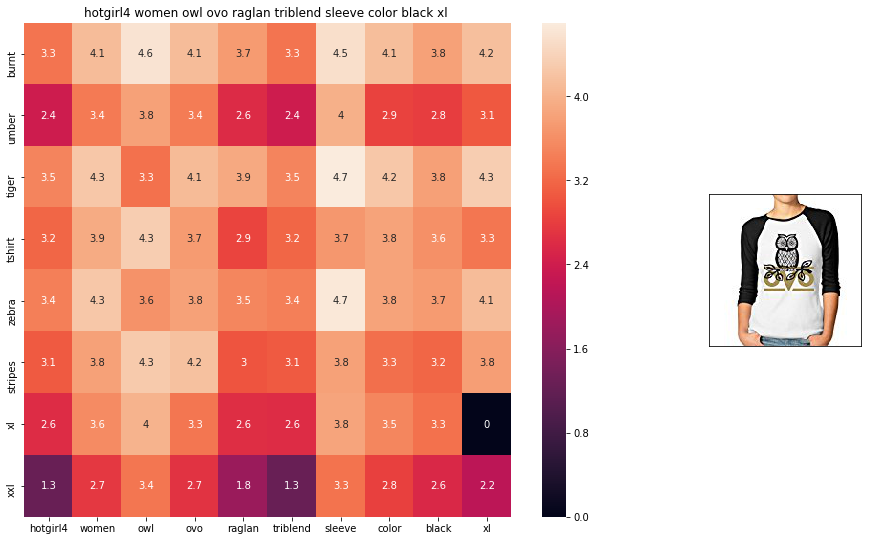

ASIN : B01L8L73M2
BRAND : Hotgirl4 Raglan Design
euclidean distance from given input image : 1.07314


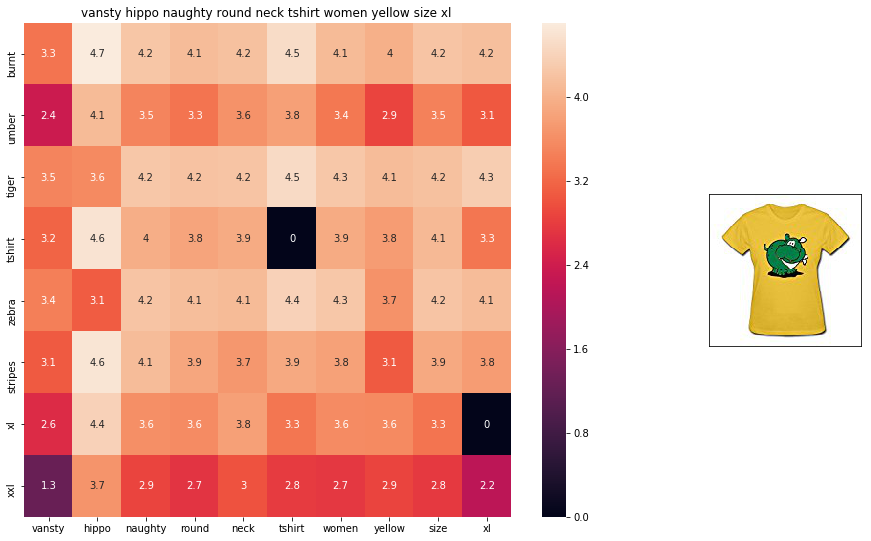

ASIN : B01EJS5H06
BRAND : Vansty
euclidean distance from given input image : 1.07572


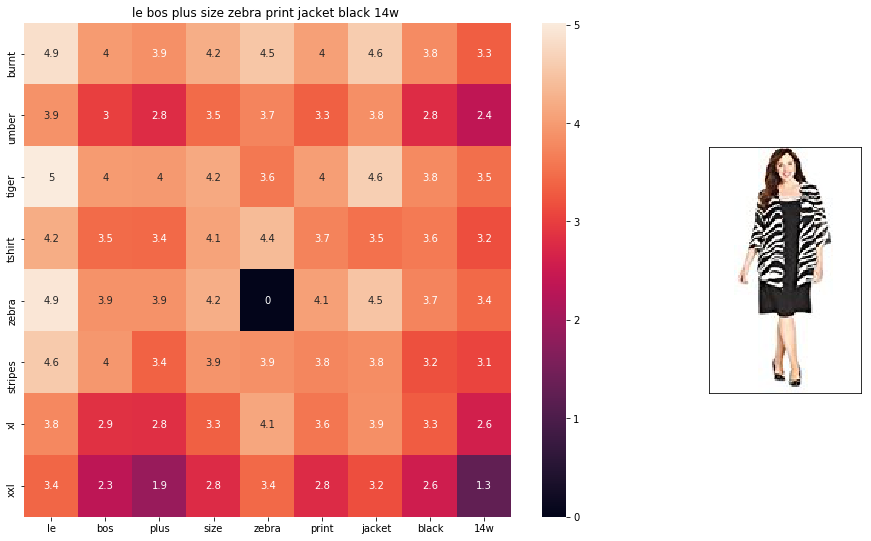

ASIN : B01BO1XRK8
BRAND : Le Bos
euclidean distance from given input image : 1.084


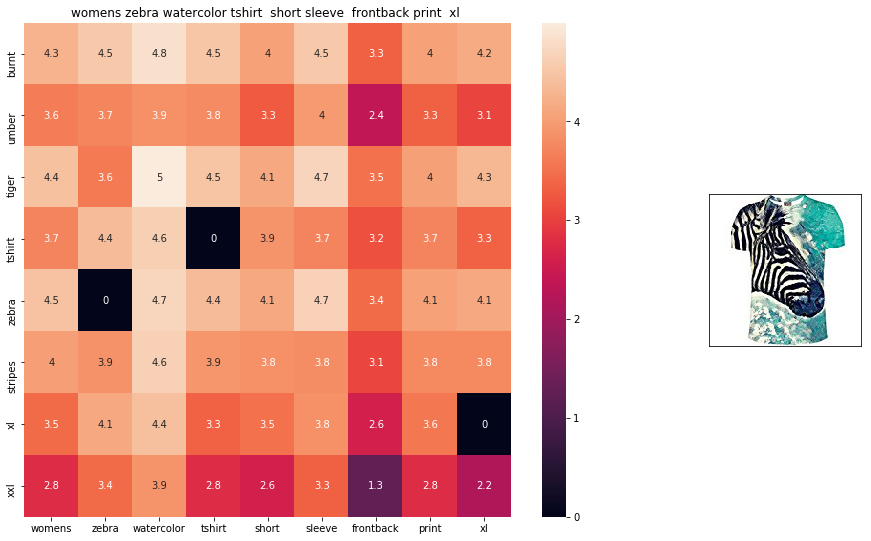

ASIN : B072R2JXKW
BRAND : WHAT ON EARTH
euclidean distance from given input image : 1.08422


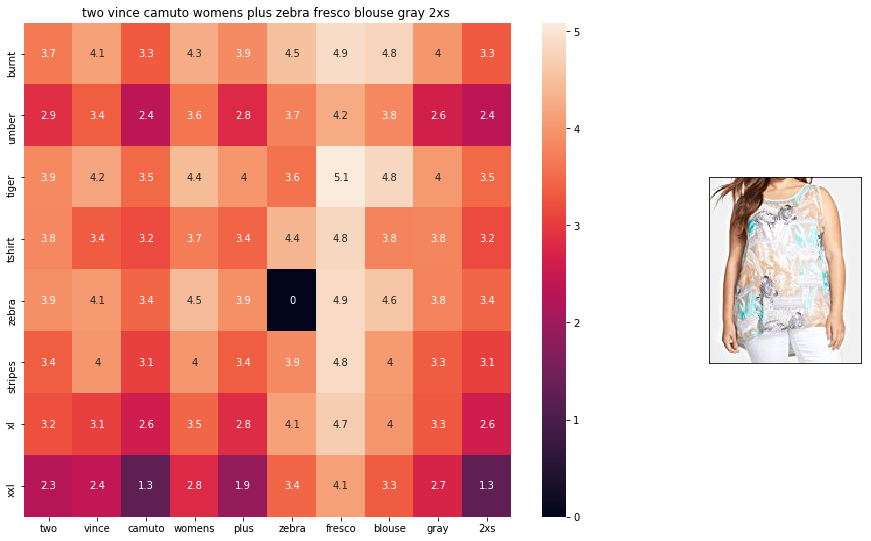

ASIN : B074MJRGW6
BRAND : Two by Vince Camuto
euclidean distance from given input image : 1.0895


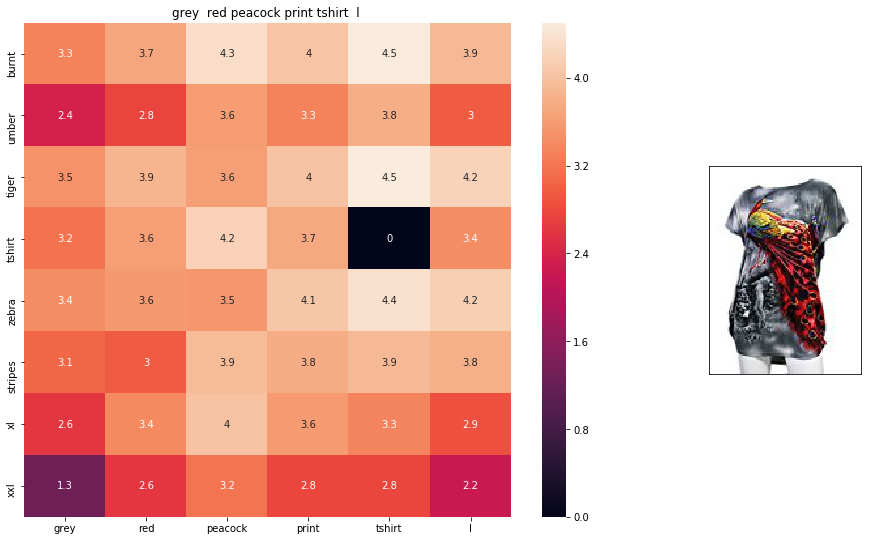

ASIN : B00JXQCFRS
BRAND : Si Row
euclidean distance from given input image : 1.09006


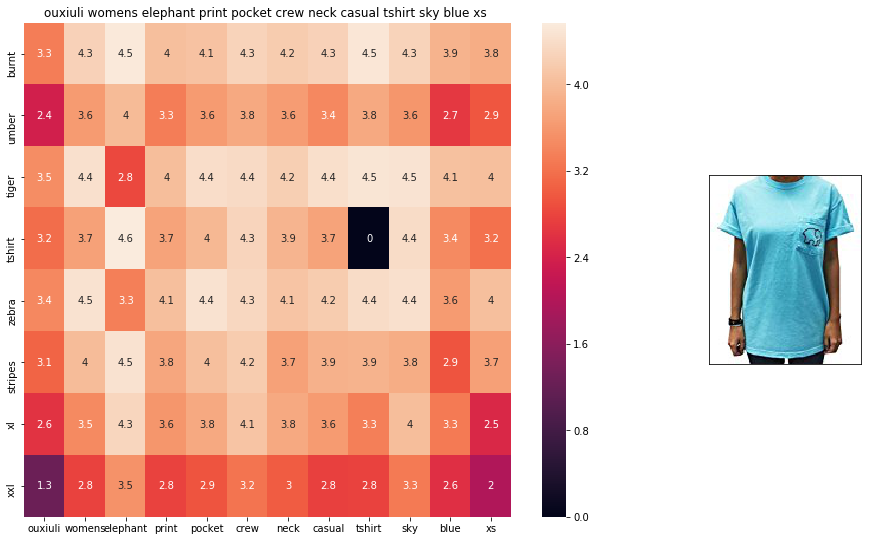

ASIN : B01I53HU6K
BRAND : ouxiuli
euclidean distance from given input image : 1.09201


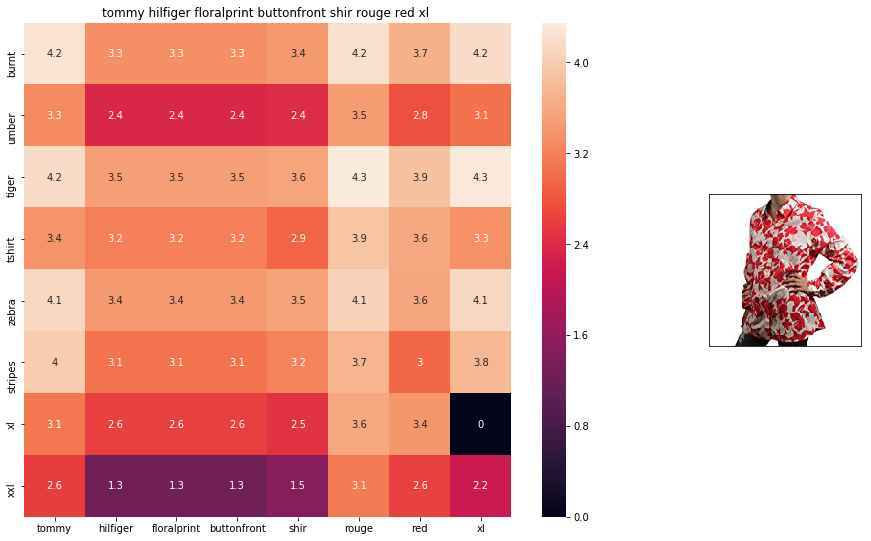

ASIN : B0711NGTQM
BRAND : THILFIGER RTW
euclidean distance from given input image : 1.09234


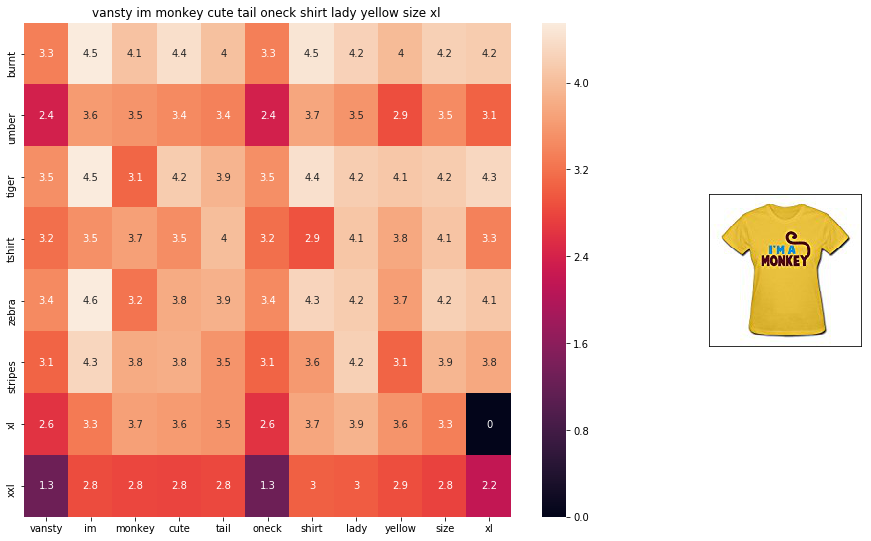

ASIN : B01EFSLO8Y
BRAND : Vansty
euclidean distance from given input image : 1.0934


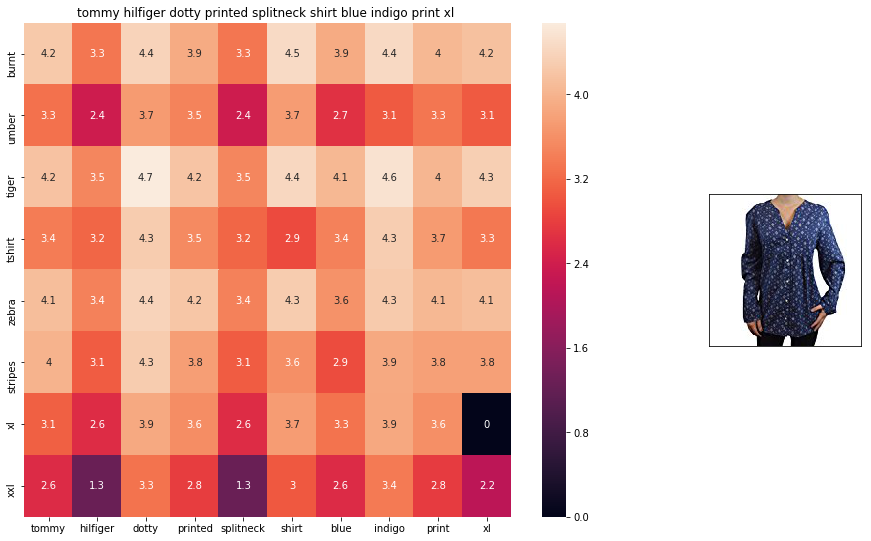

ASIN : B0716TVWQ4
BRAND : THILFIGER RTW
euclidean distance from given input image : 1.0942


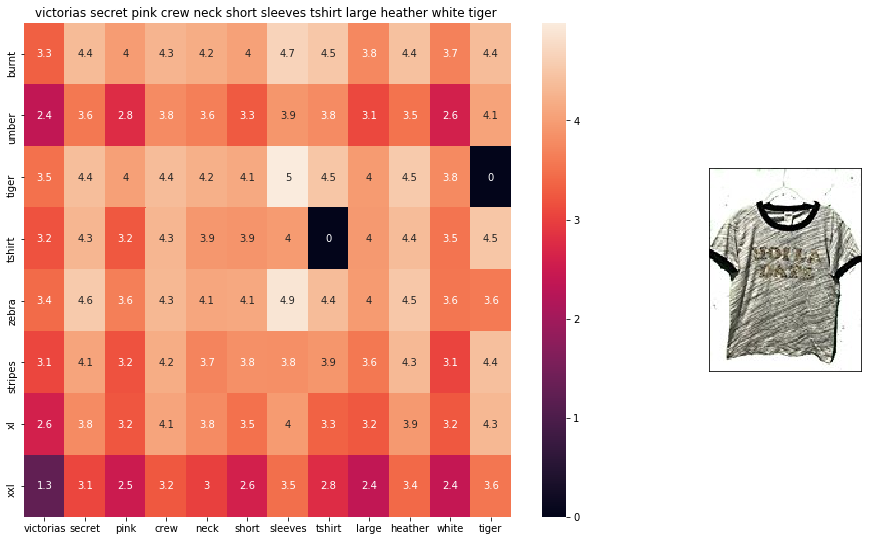

ASIN : B0716MVPGV
BRAND : V.Secret
euclidean distance from given input image : 1.09483


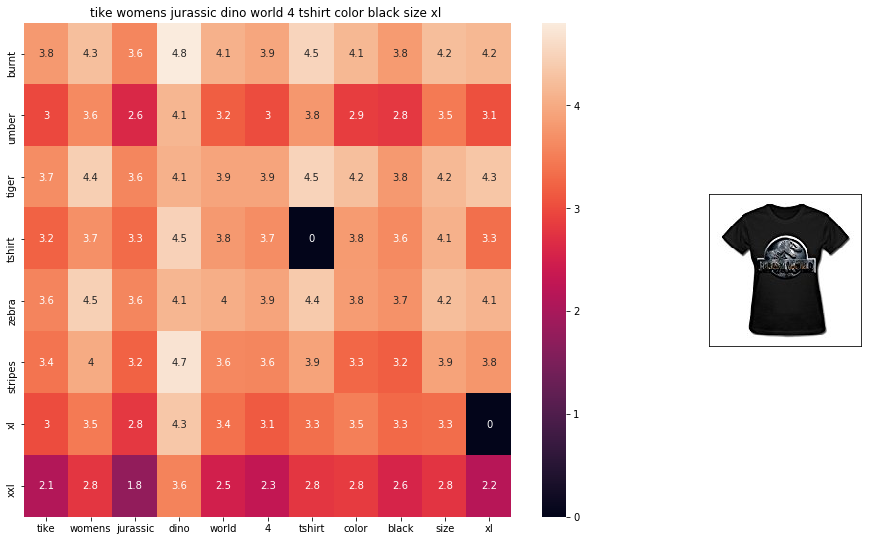

ASIN : B016OPN4OI
BRAND : TIKE Fashions
euclidean distance from given input image : 1.09513


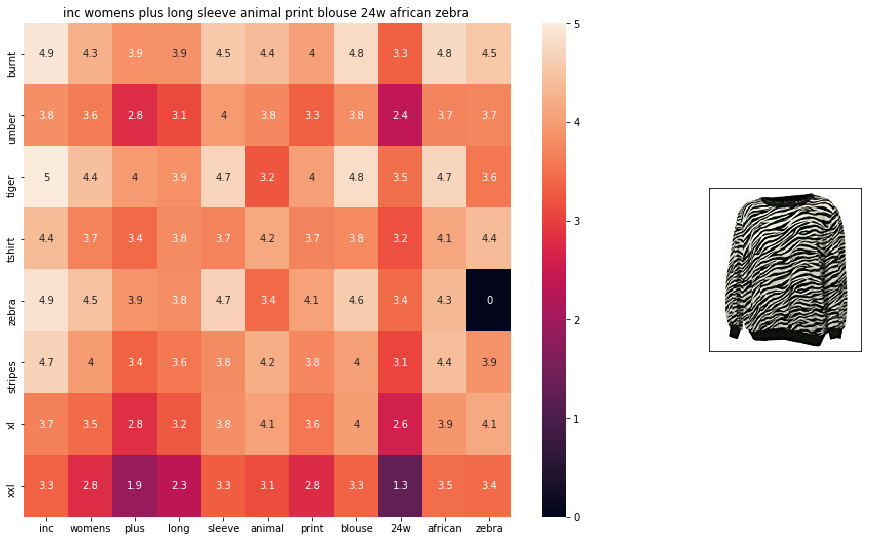

ASIN : B018WDJCUA
BRAND : INC - International Concepts Woman
euclidean distance from given input image : 1.09669


In [0]:
def avg_w2v_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # dist(x, y) = sqrt(dot(x, x) - 2 * dot(x, y) + dot(y, y))
    pairwise_dist = pairwise_distances(w2v_title, w2v_title[doc_id].reshape(1,-1))

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'avg')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('euclidean distance from given input image :', pdists[i])
        print('='*125)

        
avg_w2v_model(12566, 20)
# in the give heat map, each cell contains the euclidean distance between words i, j

###   IDF weighted Word2Vec for product similarity

In [0]:
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

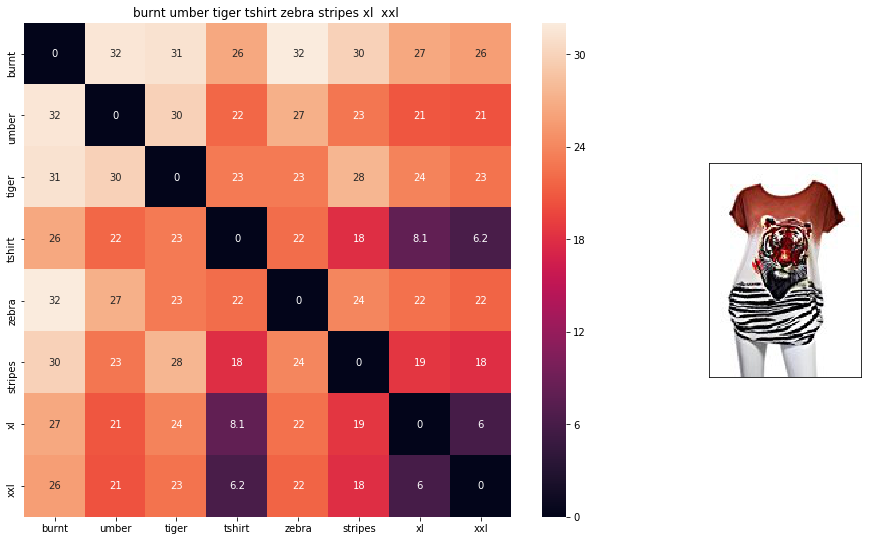

ASIN : B00JXQB5FQ
Brand : Si Row
euclidean distance from input : 0.00390625


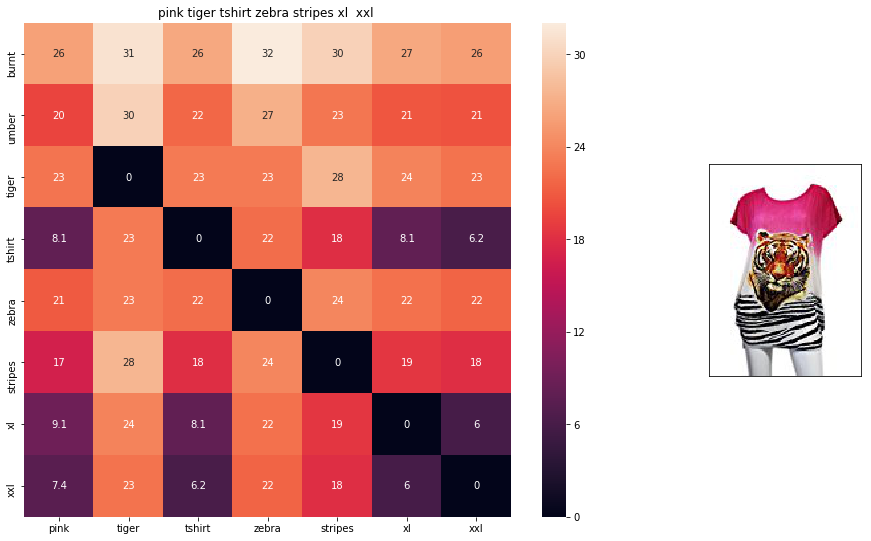

ASIN : B00JXQASS6
Brand : Si Row
euclidean distance from input : 4.06389


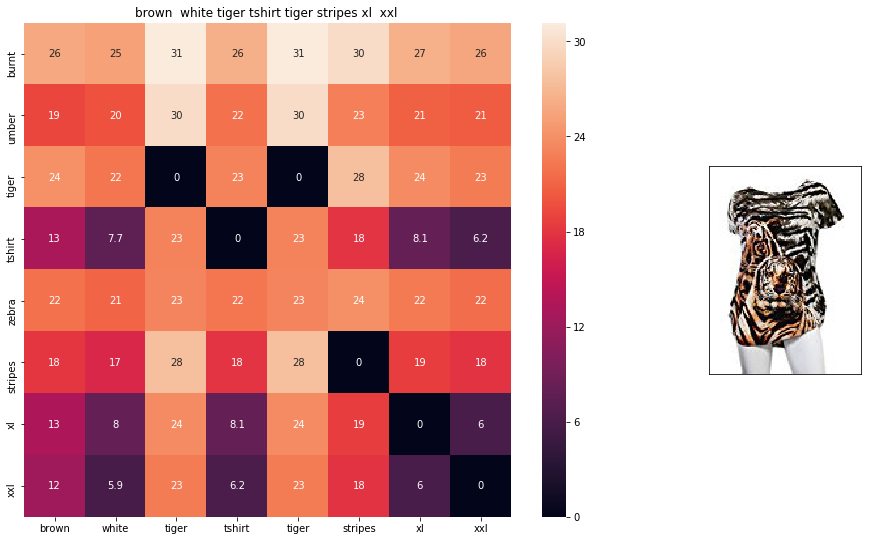

ASIN : B00JXQCWTO
Brand : Si Row
euclidean distance from input : 4.77094


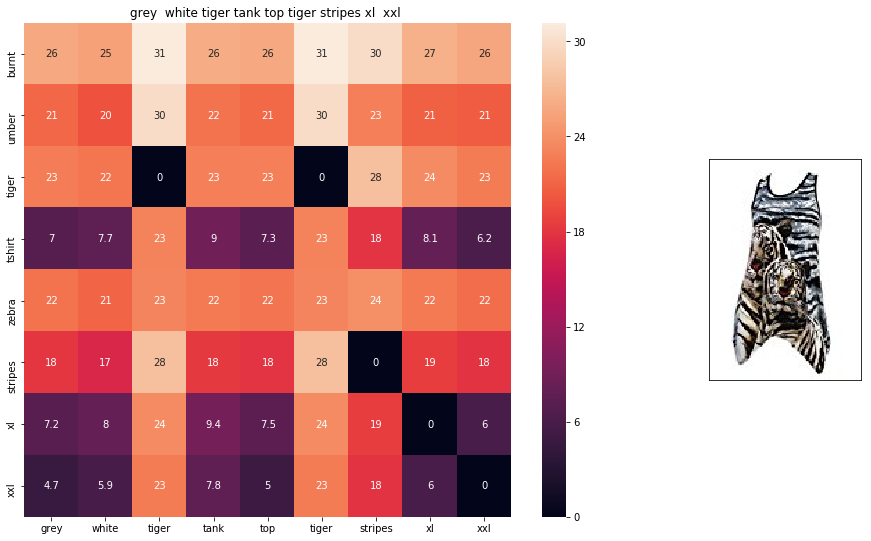

ASIN : B00JXQAFZ2
Brand : Si Row
euclidean distance from input : 5.36016


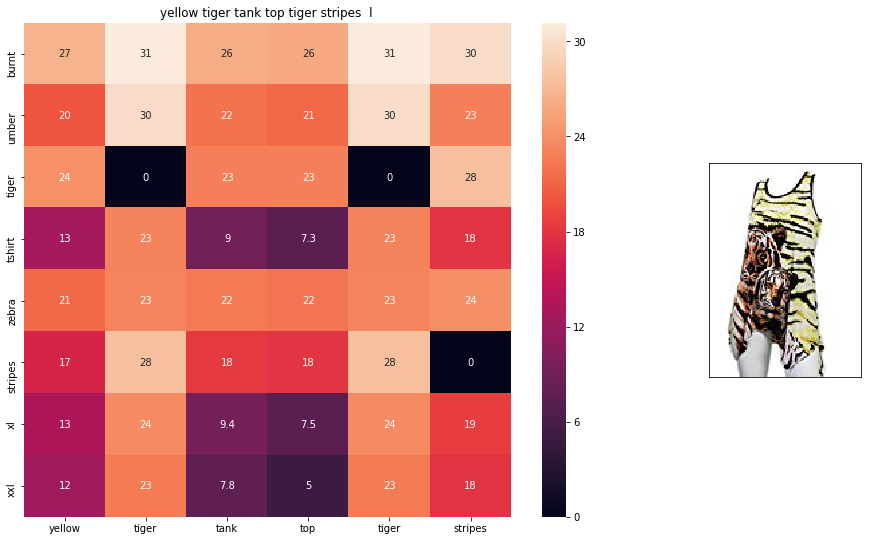

ASIN : B00JXQAUWA
Brand : Si Row
euclidean distance from input : 5.68952


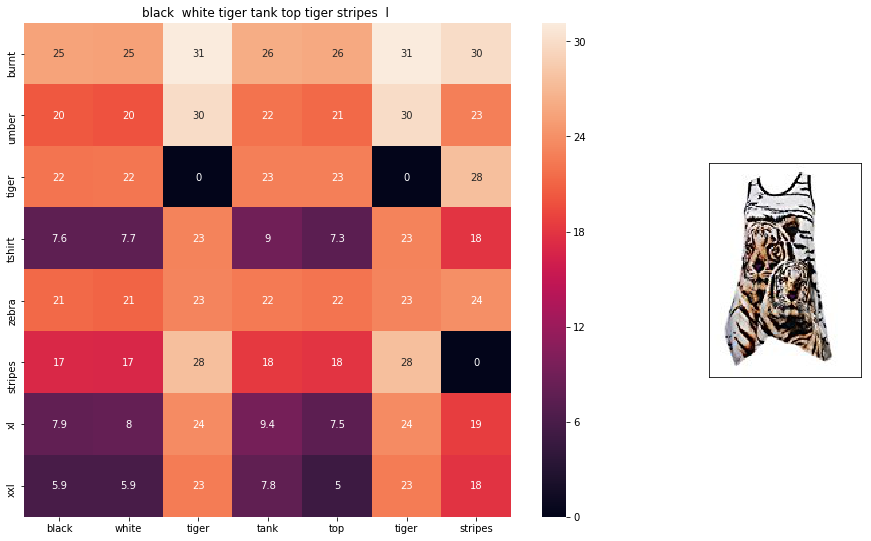

ASIN : B00JXQAO94
Brand : Si Row
euclidean distance from input : 5.69302


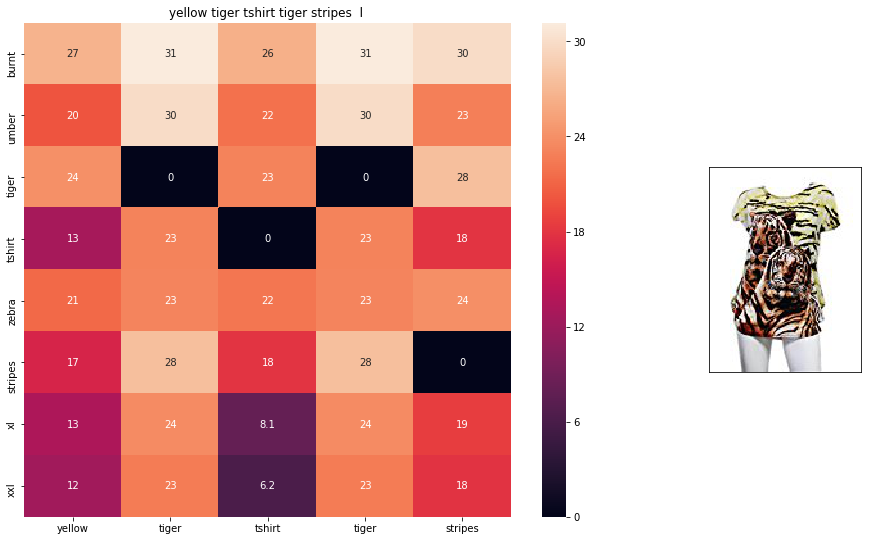

ASIN : B00JXQCUIC
Brand : Si Row
euclidean distance from input : 5.89344


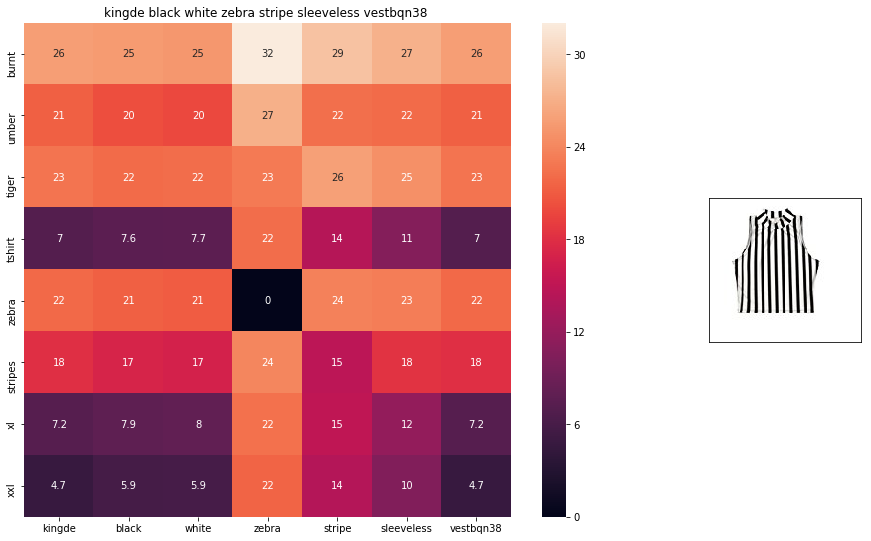

ASIN : B015H41F6G
Brand : KINGDE
euclidean distance from input : 6.13299


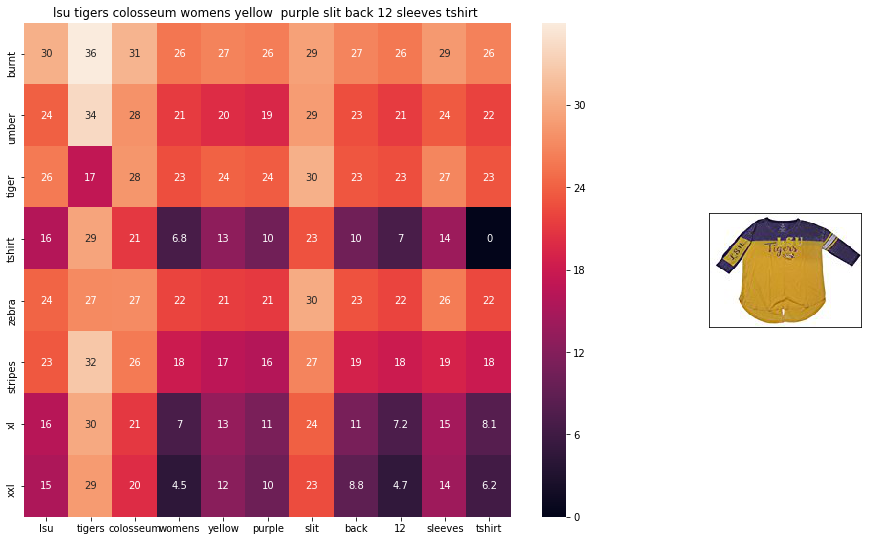

ASIN : B073R5Q8HD
Brand : Colosseum
euclidean distance from input : 6.25671


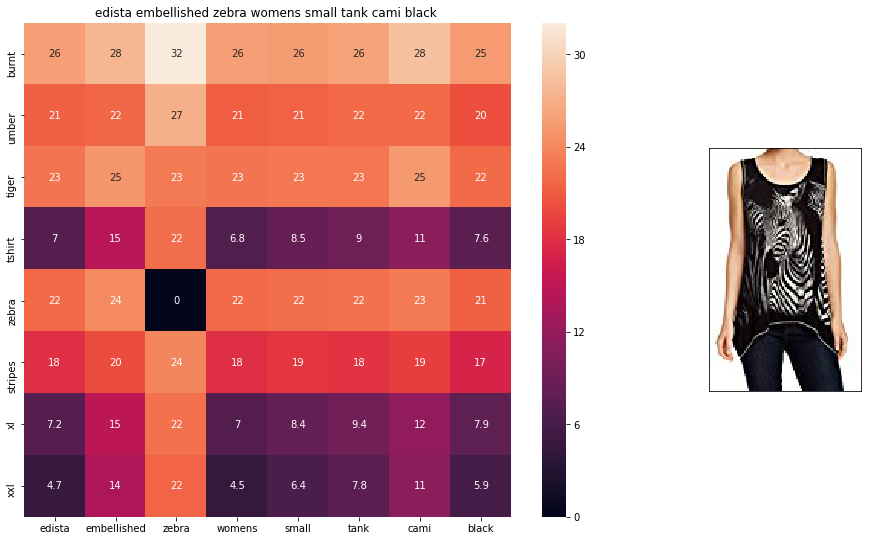

ASIN : B074P8MD22
Brand : Edista
euclidean distance from input : 6.3922


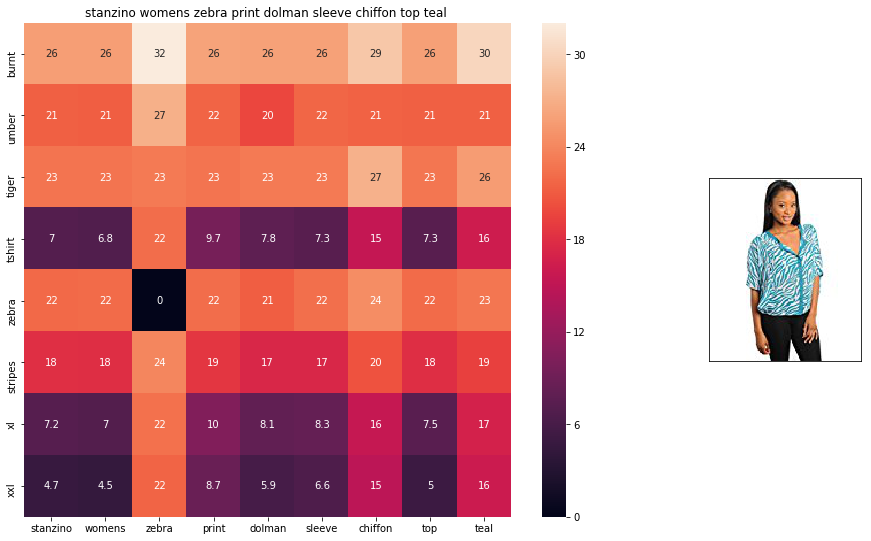

ASIN : B00C0I3U3E
Brand : Stanzino
euclidean distance from input : 6.4149


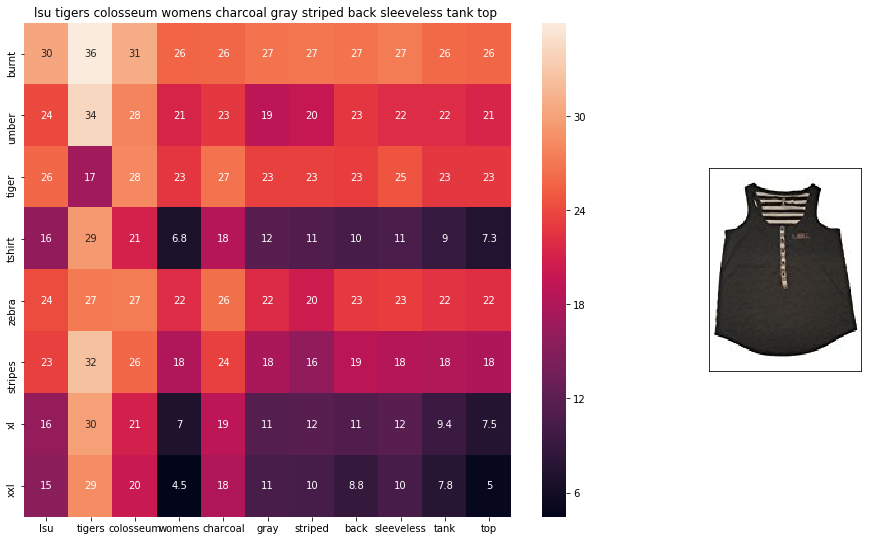

ASIN : B073R4ZM7Y
Brand : Colosseum
euclidean distance from input : 6.45096


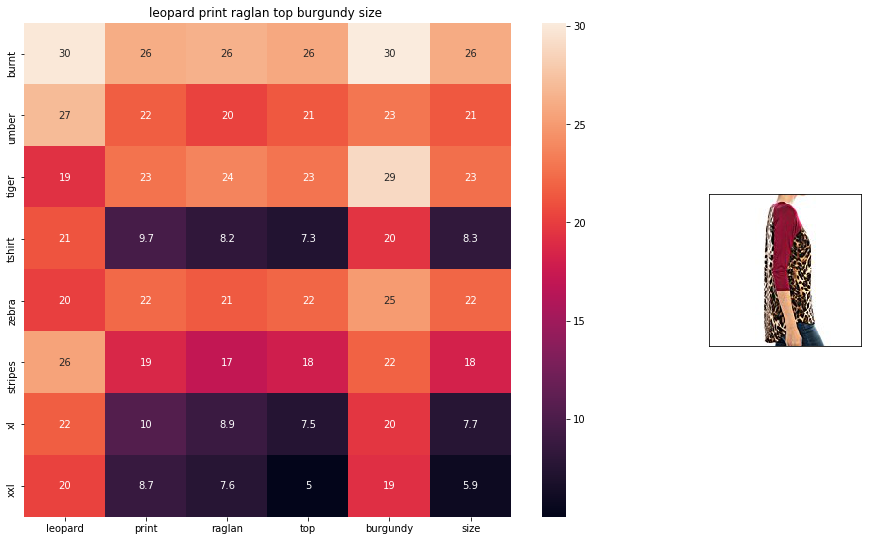

ASIN : B01C6ORLDQ
Brand : 1 Mad Fit
euclidean distance from input : 6.46341


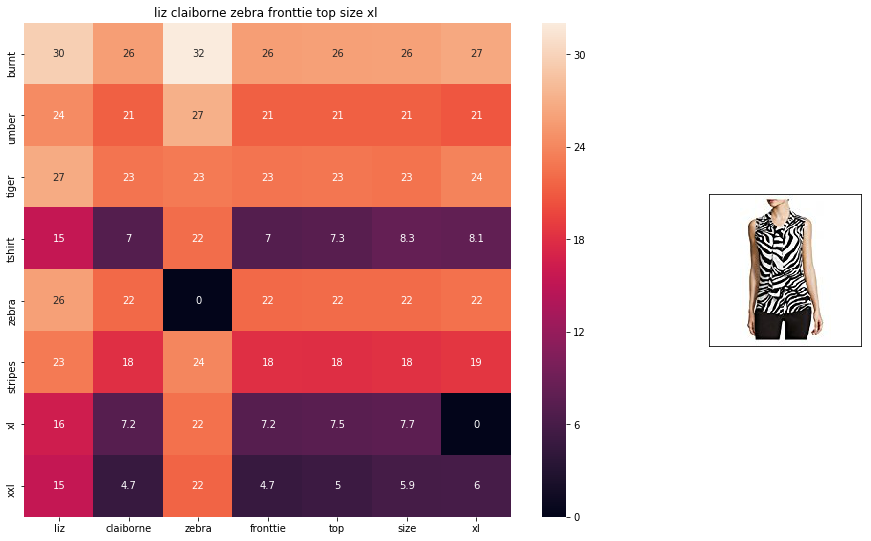

ASIN : B06XBY5QXL
Brand : Liz Claiborne
euclidean distance from input : 6.53922


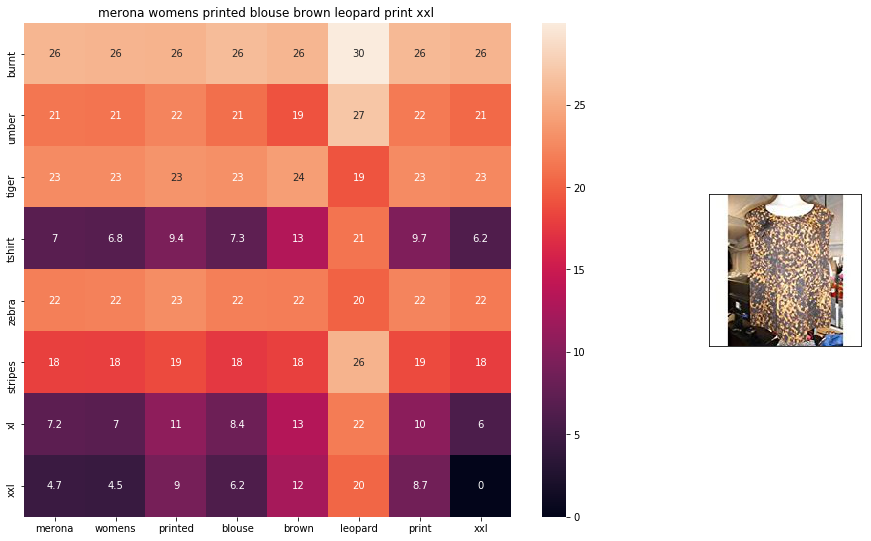

ASIN : B071YF3WDD
Brand : Merona
euclidean distance from input : 6.5755


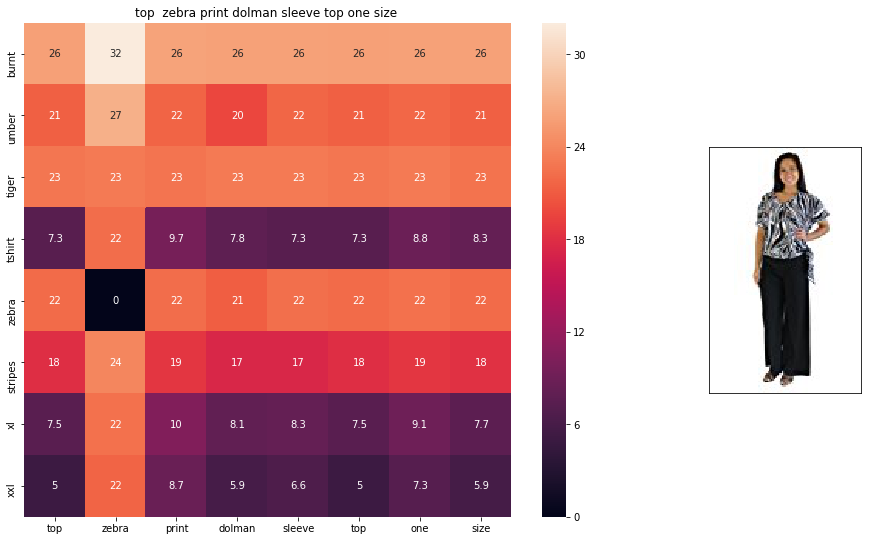

ASIN : B00H8A6ZLI
Brand : Vivian's Fashions
euclidean distance from input : 6.63821


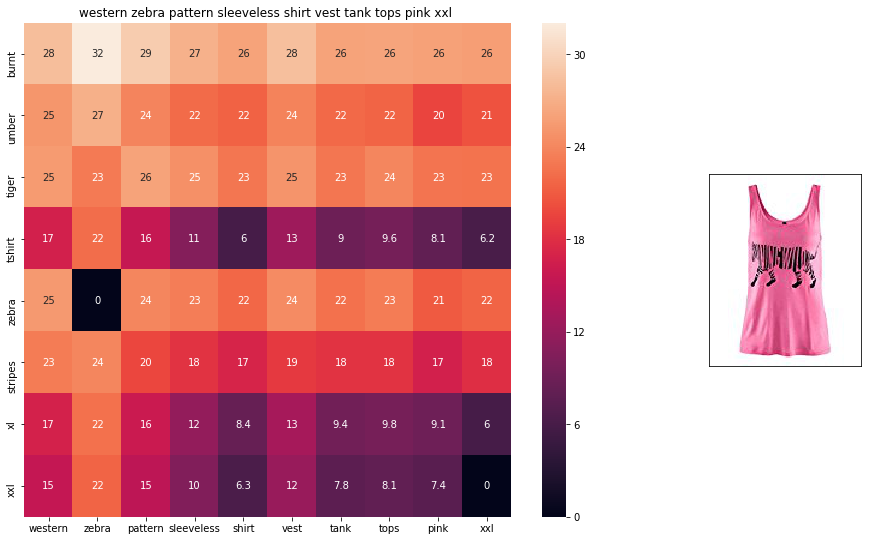

ASIN : B00Z6HEXWI
Brand : Black Temptation
euclidean distance from input : 6.66074


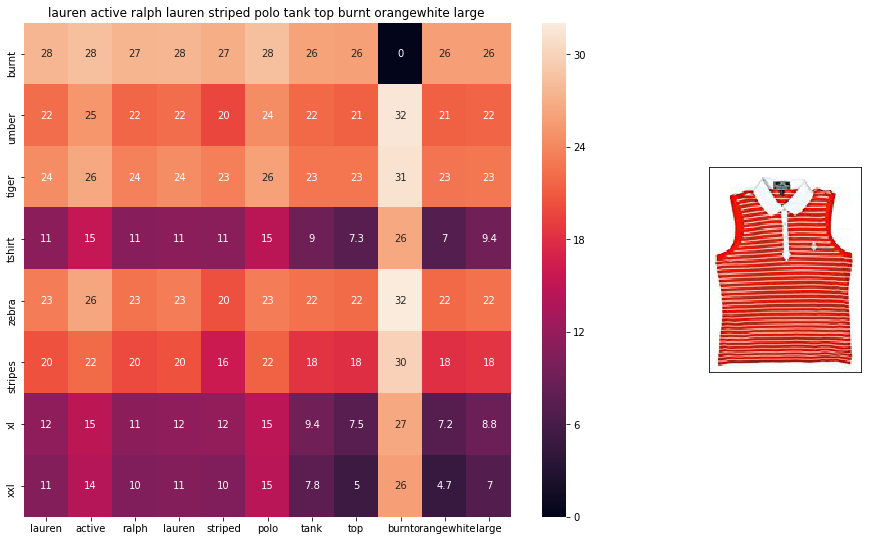

ASIN : B00ILGH5OY
Brand : Ralph Lauren Active
euclidean distance from input : 6.68391


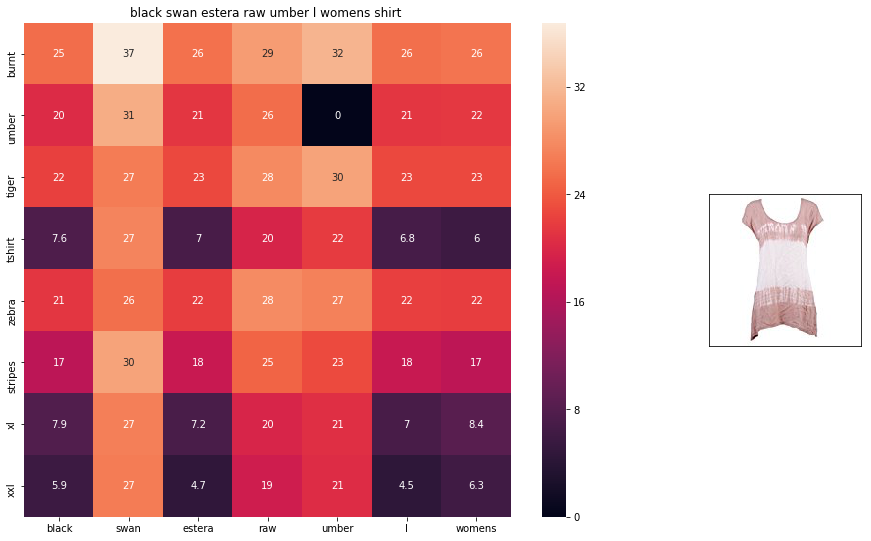

ASIN : B06Y1VN8WQ
Brand : Black Swan
euclidean distance from input : 6.70576


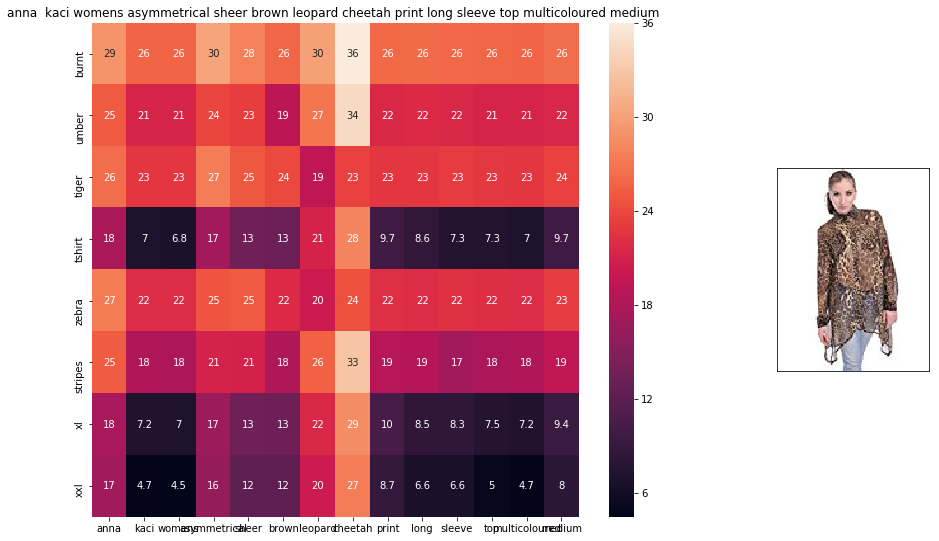

ASIN : B00KSNTY7Y
Brand : Anna-Kaci
euclidean distance from input : 6.70612


In [0]:
def weighted_w2v_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

weighted_w2v_model(12566, 20)
#931
#12566
# in the give heat map, each cell contains the euclidean distance between words i, j